In [3]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from py2neo import Graph
from sklearn.decomposition import PCA

## Get data from database

In [6]:
url = "neo4j://localhost:7687"
username = "neo4j"
password = "pleaseletmein"

session = Graph("bolt://localhost:7687", auth=("neo4j", password))

In [7]:
query = ''' MATCH (p:Person) RETURN p.name, p.embedding; '''
result = session.run(query).data()
df = DataFrame(result)

rename to work with them

In [8]:
df.columns = ["name", "embedding"]

In [9]:
df.head()

,name,embedding
0,Harry,"[0.0554661899805069, 0.08762118965387344, -0.0..."
1,Scabbers,"[0.0447714626789093, 0.04372702166438103, -0.0..."
2,Fred,"[0.04668577387928963, 0.06711672246456146, -0...."
3,Ron,"[0.058472584933042526, 0.07164731621742249, -0..."
4,Molly Weasley,"[0.056798167526721954, 0.11087218672037125, -0..."


Devide embedding into multiple collums

In [10]:
df2 = df.embedding.apply(pd.Series)

In [11]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.055466,0.087621,-0.019244,0.014202,-0.009242,0.031933,0.003700,0.026133,0.004648,0.039380,...,0.012821,-0.010130,-0.025638,0.018612,-0.008648,0.067806,0.019772,0.025388,-0.032526,-0.007751
1,0.044771,0.043727,-0.006938,0.000170,-0.035803,0.016572,-0.012374,0.021241,-0.020275,0.037608,...,0.006265,0.001647,-0.020053,0.024196,-0.013570,0.041651,0.016404,-0.012378,-0.037346,-0.000714
2,0.046686,0.067117,-0.029435,0.017139,-0.005652,0.016713,-0.013537,0.017123,-0.005586,0.049403,...,0.013913,-0.015419,-0.043027,0.027712,-0.008111,0.054666,0.047241,0.008439,-0.041302,-0.010776
3,0.058473,0.071647,-0.032466,0.018605,-0.016124,0.027574,-0.019245,0.025642,-0.036690,0.034690,...,0.026460,0.000926,-0.056994,0.033778,0.000064,0.057588,0.038908,0.006456,-0.047205,-0.004311
4,0.056798,0.110872,-0.022339,0.028292,0.015429,0.016162,-0.011286,0.008113,-0.007605,0.039157,...,0.004324,0.007378,0.001663,0.016952,0.004773,0.088571,0.007243,0.007345,-0.025943,-0.008234


### PCA
Use PCA to boild it down into two collums, inorder to make a diagram.

In [12]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(df2)

In [13]:
pca_df = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])

In [14]:
pca_df.head()

,PC 1,PC 2
0,0.128165,-0.076970
1,-0.204104,-0.056333
2,-0.186412,-0.043335
3,-0.168415,-0.026620
4,0.284361,-0.075856


In [15]:
pca_df[pca_df["PC 2"] > 4]

,PC 1,PC 2


### Elbow
We made an elbow diagram inorder to determent how many clusters there should be

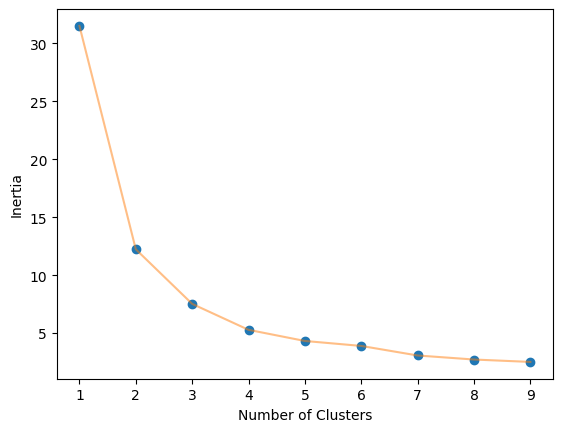

In [16]:
import numpy as np
from sklearn.cluster import KMeans

def elbow_plot(data,clusters):
    inertia = []
    for n in range(1, clusters):
        algorithm = KMeans(
            n_clusters=n,
            init="k-means++",
            random_state=125,
        )
        algorithm.fit(data)
        inertia.append(algorithm.inertia_)
    # Plot
    plt.plot(np.arange(1 , clusters) , inertia , 'o')
    plt.plot(np.arange(1 , clusters) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.show();

elbow_plot(pca_df,10)

It's difficult to determent how many clusters there need to be from the elbow diagram, but we're going with 3.

### Silhouette score
To insure the number of clusters we made a silhouette diagram, but as shown it did not help a lot.

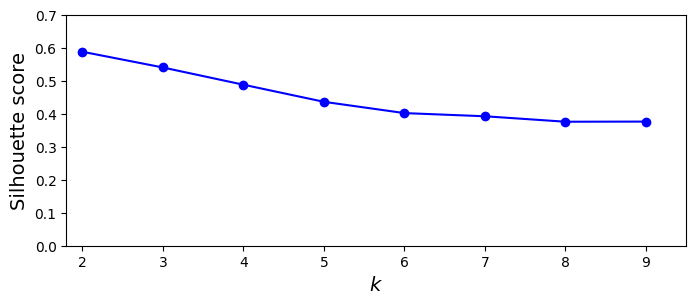

In [17]:
from sklearn.metrics import silhouette_score

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(pca_df)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]


silhouette_scores = [silhouette_score(pca_df, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 9.5, 0, 0.7])
plt.show()

### KNN

Despite the bad silhouette score, we decided to go with 3 clusters and it fits well when we illustrate it in the diagram.

In [18]:
kmeans = KMeans(n_clusters=2, n_init=1000, random_state=42)
kmeans.fit(pca_df)

KMeans(n_clusters=2, n_init=1000, random_state=42)

<Axes: xlabel='PC 1', ylabel='PC 2'>

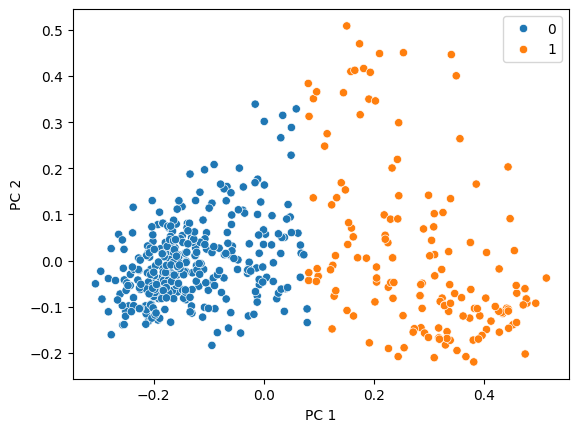

In [19]:

import seaborn as sns
sns.scatterplot(x = "PC 1", y = "PC 2", data = pca_df, hue = kmeans.labels_)

In [20]:
kmeans = KMeans(n_clusters=3, n_init=1000, random_state=42)
kmeans.fit(pca_df)

KMeans(n_clusters=3, n_init=1000, random_state=42)

<Axes: xlabel='PC 1', ylabel='PC 2'>

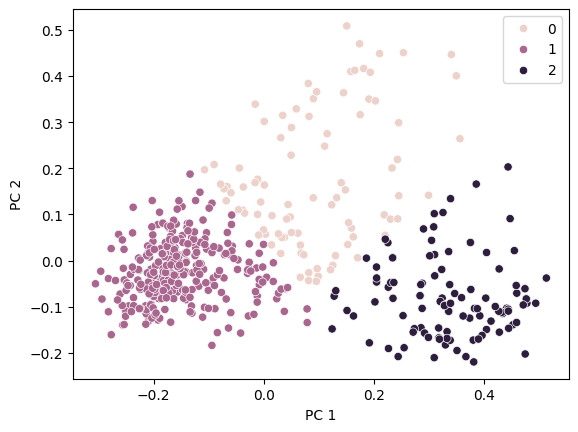

In [21]:
sns.scatterplot(x = "PC 1", y = "PC 2", data = pca_df, hue = kmeans.labels_)